# Xarray使用技巧--滤波

将介绍利用xarray的`rolling()`函数进行滤波：例如滑动平均、Lanczos滤波（Lanczos滤波参数由ncl获得）。将用北大西洋区域平均的海温距平来介绍xarray的滤波处理。数据和相关库的介绍如下：
- **python：** 3.8.8
- **xarray：** 0.20.1
- **matplotlib：** 3.5.0
- **cartopy：** 0.19.0
- **numpy：** 1.19.5
- **NOAA EXTENDED RECONSTRUCTION SSTS VERSION 5 (ERSSTV5)：**[下载链接1](https://climatedataguide.ucar.edu/climate-data/sst-data-noaa-extended-reconstruction-ssts-version-5-ersstv5)、[下载链接2](https://psl.noaa.gov/data/gridded/data.noaa.ersst.v5.html)

导入相关的库，并读取ERSSTV5海温数据，选择时间范围为1870～2015，并且选择北大西洋区域（0～60˚N，0～80˚W）.定义一个绘图函数，绘制北大西洋海温气候态。

In [57]:
import xarray as xr 
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
import numpy as np
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
file = 'sst.mnmean.nc'
sst = xr.open_dataset(file).sel(time = slice('1870','2015'),lat = slice(60,0),lon = slice(280,360)).sst
print(sst.coords)
###定义绘图函数
def NA_plot():
    ## 定义画布
    fig = plt.figure(figsize=(6,6))
    ## 定义绘图区域和投影类型
    # proj = ## 设置投影的中心经度为180度
    ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
    ## 绘制经纬度坐标
    ax.set_xticks(np.arange(-80,0+20,20))
    ax.set_yticks(np.arange(0,60+20,20))
    ax.xaxis.set_major_formatter(LongitudeFormatter())#刻度格式转换为经纬度样式 
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ## 返回绘图区域ax
    return ax  

def line_plot():
    ## 定义画布
    fig = plt.figure(figsize=(12,4))
    ## 定义绘图区域和投影类型
    # proj = ## 设置投影的中心经度为180度
    ax = fig.add_subplot(111)
    return ax

Coordinates:
  * lat      (lat) float32 60.0 58.0 56.0 54.0 52.0 50.0 ... 8.0 6.0 4.0 2.0 0.0
  * lon      (lon) float32 280.0 282.0 284.0 286.0 ... 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1870-01-01 1870-02-01 ... 2015-12-01


## 计算北大西洋区域海温距平
首先看一下北大西洋的海温气候态情况

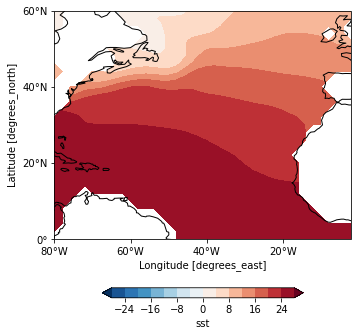

In [34]:
p = sst.mean(dim = 'time').plot.contourf(ax = NA_plot(),cmap=plt.cm.RdBu_r,levels = 15,extend = 'both',
                                         transform =ccrs.PlateCarree(),
                                         cbar_kwargs = {'orientation':'horizontal','shrink':0.6,'pad':0.15})
p.axes.coastlines()## 添加海岸线

计算北大西洋区域海温距平(考虑纬度权重)

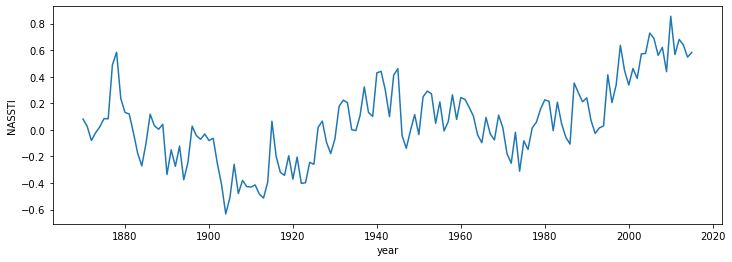

In [52]:
### 纬度权重
weights = np.cos(np.deg2rad(sst.lat))
weights.name = "weights"
### 计算年平均
sst_annual_mean = sst.groupby("time.year").mean()
### 计算年平均气候态，以整个20世纪的海温为气候态
sst_annual_mean_cli = sst_annual_mean.sel(year = slice("1901","2000")).mean(dim = "year")
### 计算北大西洋区域海温距平
NASSTI = (sst_annual_mean - sst_annual_mean_cli).weighted(weights).mean(dim = ["lat","lon"]).rename("NASSTI")
### 绘图
p = NASSTI.plot(figsize =(12,4))

## 滤波
### 1.使用滑动平均
为了反应北大西洋海温的多年代际振荡，可以使用11点滑动平均，相当于做了低通滤波。

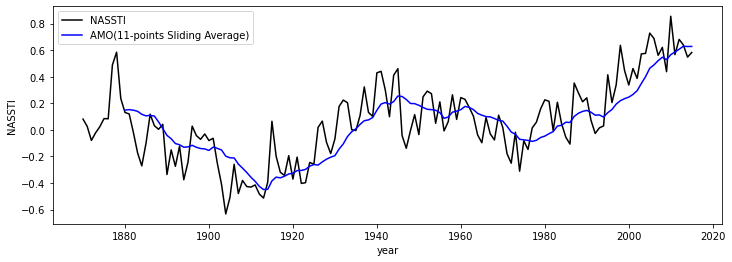

In [60]:
AMO = NASSTI.rolling(year = 11).mean()
ax = line_plot()
NASSTI.plot(ax = ax,color = 'k',label = 'NASSTI')
AMO.plot(ax = ax,color = 'b',label = 'AMO(11-points Sliding Average)')
ax.legend()

### 2.Lanczos 低通滤波
使用ncl生成Lanczos的滤波参数如下图所示。读取滤波参数后进行滤波处理。
<div align=left>
<img src="./NCL滤波代码.png" /><img src="./滤波参数.png"/>
</div>

<xarray.DataArray (window: 11)>
array([-5.838655e-10,  1.984002e-02,  6.589867e-02,  1.284073e-01,
        1.832743e-01,  2.051594e-01,  1.832743e-01,  1.284073e-01,
        6.589867e-02,  1.984002e-02, -5.838655e-10])
Dimensions without coordinates: window


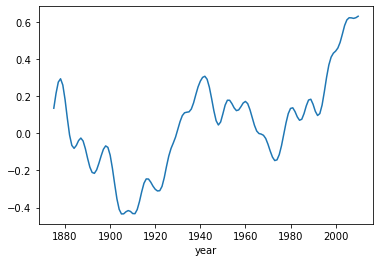

In [68]:
### 读取ncl输出的txt文件，获取滤波参数
def load_lanczos_wgt(filepath):
    wgt = []
    with open(filepath,'r') as f:
        for lines in f.readlines():
            wgt.append(float(lines.strip("\n")))
        # wgt.append(f.readlines().strip("\n"))
    # print(wgt)
    return wgt
weights = load_lanczos_wgt('Lanczos_weight.txt')
### 将weights写成DataArray形式
weight = xr.DataArray(weights, dims=['window'])
print(weight)
AMO = NASSTI.rolling(year=len(weights), center=True).construct('window').dot(weight).dropna(dim = "year")
AMO.plot()

将两种方法汇总于一张图上

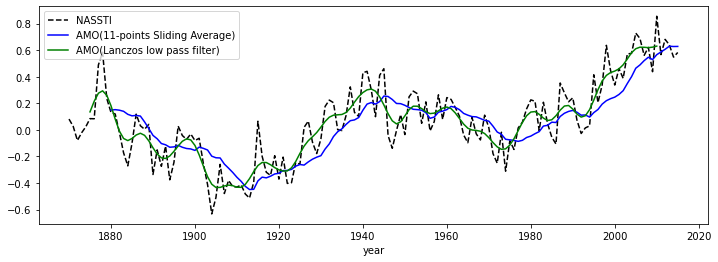

In [72]:
### 滑动平均
AMO_sliding = NASSTI.rolling(year = 11).mean()
### lanczos滤波
AMO_lan = NASSTI.rolling(year=len(weights), center=True).construct('window').dot(weight).dropna(dim = "year")
### 绘图
ax = line_plot()
NASSTI.plot(ax = ax,color = 'k',linestyle = 'dashed',label = 'NASSTI')
AMO_sliding.plot(ax = ax,color = 'b',label = 'AMO(11-points Sliding Average)')
AMO_lan.plot(ax = ax,color = 'g',label = 'AMO(Lanczos low pass filter)')
ax.legend(loc = 'upper left')